In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, precision_recall_curve

import tensorflow as tf
import keras 

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, InputLayer, Flatten, Conv2D, MaxPooling2D

np.random.seed(42)
tf.random.set_seed(42)

from preprocessing.getdata import *

In [2]:
df_a = get_csvdata_ADNI(False)
df_o= get_csvdata(drop_young=False, drop_contradictions=False)

df_a_train, df_a_test, y_a_train, y_a_test = train_test_split(df_a['ID'], df_a['label'], stratify=df_a['label'], random_state=42)

df_o_train, df_o_test, y_o_train, y_o_test = train_test_split(df_o['ID'], df_o['label'], stratify=df_o['label'], random_state=42)

y_test = np.concatenate((y_o_test, y_a_test))

In [4]:
N = 1
d = 2
mdict = {0: 95, 1: 110, 2: 90}

def get_test(dim, N, d):
    m = mdict[dim]
    X_test_o = get_slices(df_o_test, dim=dim, m=m, N=N, d=d)
    X_test_a = get_slices_ADNI_new(df_a_test, dim=dim, m=m, N=N, d=d)

    X_test = np.concatenate((X_test_o, X_test_a), axis=0)

    X_test = np.repeat(X_test[..., np.newaxis], 3, -1)
    return X_test

X_test0 = get_test(0, N, d)
X_test1 = get_test(1, N, d)
X_test2 = get_test(2, N, d)

In [5]:
model0 = tf.keras.models.load_model('../models/axis00')
model1 = tf.keras.models.load_model('../models/axis01')
model2 = tf.keras.models.load_model('../models/axis02')

In [6]:
y_prob0 = model0.predict(X_test0)
y_prob1 = model1.predict(X_test1)
y_prob2 = model2.predict(X_test2)

30/30 [==============================] - 41s 1s/step


In [14]:
y_prob0 = y_prob0.reshape(len(df_o_test)+len(df_a_test),1+2*N)
y_prob1 = y_prob1.reshape(len(df_o_test)+len(df_a_test),1+2*N)
y_prob2 = y_prob2.reshape(len(df_o_test)+len(df_a_test),1+2*N)

In [7]:
y_prob0 = np.mean(y_prob0, axis=1)
y_prob1 = np.mean(y_prob1, axis=1)
y_prob2 = np.mean(y_prob2, axis=1)

In [8]:
y_test = y_test.repeat(1+2*N)

In [9]:
y_test.shape

(951,)

In [10]:
print('accuracy of axis 0: ', accuracy_score(y_test, y_prob0.round()))
print('accuracy of axis 1: ', accuracy_score(y_test, y_prob1.round()))
print('accuracy of axis 2: ', accuracy_score(y_test, y_prob2.round()))

accuracy of axis 0:  0.7076761303890642
accuracy of axis 1:  0.7266035751840169
accuracy of axis 2:  0.7339642481598317


In [11]:
y_prob = np.stack((y_prob0, y_prob1, y_prob2)).T

In [12]:
y_pred = np.mean(y_prob, axis=1).round()

accuracy:  0.75
recall:  0.79
precision:  0.77


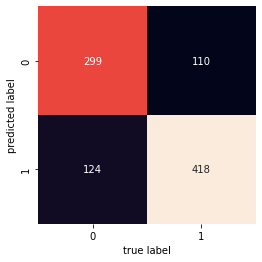

In [13]:
mat = confusion_matrix(y_test, y_pred.round())
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
print('accuracy: ' , accuracy_score(y_test, y_pred.round()).round(2))
print('recall: ' , recall_score(y_test, y_pred.round()).round(2))
print('precision: ' , precision_score(y_test, y_pred.round()).round(2))

In [75]:
mask = (y_test == 1) & (y_pred == 0)

In [119]:
mask = (y_test == 0) & (y_pred == 1)

In [120]:
dff = pd.concat([pd.merge(df_o_test, df_o), pd.merge(df_a_test, df_a)])

In [121]:
dff[mask].groupby('Group').count()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,...,dataset,Image Data ID,Sex,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
Group,,,,,,,,,,,,,,,,,,,,,
CN,49,0,0,49,0,0,0,0,0,0,...,49,49,49,49,49,49,49,49,49,49


In [32]:
N = 0
d = 5
mdict = {0: 95, 1: 110, 2: 90}

def get_test(dim, N, d, m):
    X_test_o = get_slices(df_o_test, dim=dim, m=m, N=N, d=d)
    X_test_a = get_slices_ADNI_new(df_a_test, dim=dim, m=m, N=N, d=d)

    X_test = np.concatenate((X_test_o, X_test_a), axis=0)

    X_test = np.repeat(X_test[..., np.newaxis], 3, -1)
    return X_test



In [33]:
results0 = []
results1 = []
results2 = []
for m in range(70,120,5):
    X_test0 = get_test(0, N, d, m)
    X_test1 = get_test(1, N, d, m)
    X_test2 = get_test(2, N, d, m)
    y_prob0 = model0.predict(X_test0)
    y_prob1 = model1.predict(X_test1)
    y_prob2 = model2.predict(X_test2)
    results0.append(accuracy_score(y_test, y_prob0.round()))
    results1.append(accuracy_score(y_test, y_prob1.round()))
    results2.append(accuracy_score(y_test, y_prob2.round()))
    print(results0, results1, results2)

10/10 [==============================] - 14s 1s/step
[0.7192429022082019] [0.7318611987381703] [0.7570977917981072]
10/10 [==============================] - 14s 1s/step
[0.7192429022082019, 0.722397476340694] [0.7318611987381703, 0.6845425867507886] [0.7570977917981072, 0.7697160883280757]
10/10 [==============================] - 14s 1s/step
[0.7192429022082019, 0.722397476340694, 0.7539432176656151] [0.7318611987381703, 0.6845425867507886, 0.7066246056782335] [0.7570977917981072, 0.7697160883280757, 0.7287066246056783]
10/10 [==============================] - 14s 1s/step
[0.7192429022082019, 0.722397476340694, 0.7539432176656151, 0.7255520504731862] [0.7318611987381703, 0.6845425867507886, 0.7066246056782335, 0.6813880126182965] [0.7570977917981072, 0.7697160883280757, 0.7287066246056783, 0.7570977917981072]
10/10 [==============================] - 14s 1s/step
[0.7192429022082019, 0.722397476340694, 0.7539432176656151, 0.7255520504731862, 0.7413249211356467] [0.7318611987381703, 0.684

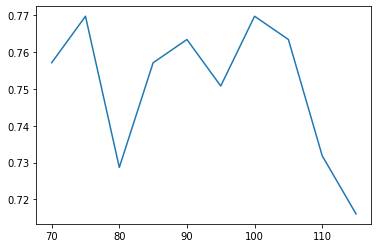

In [36]:
plt.plot(range(70,120,5), results2)